In [36]:
import re
from enum import Enum
from typing import List, Tuple, Dict, Set, Optional, Union, Any, Callable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [37]:
def replace_multiple_spaces_by_one(s):
    return re.sub(r" +", " ", s)

In [38]:
class Unit(Enum):
    ns = 1000000000
    us = 1000000
    ms = 1000
    s = 1

    def __str__(self):
        return self.name

def get_unit(s):
    unit = s.replace("/op", "")
    if unit == "ns":
        return Unit.ns
    elif unit == "us":
        return Unit.us
    elif unit == "ms":
        return Unit.ms
    elif unit == "s":
        return Unit.s
    else:
        raise Exception("Unknown unit")
    
def convert(n:float, current_unit:Unit, new_unit:Unit) -> float:
    return n * current_unit.value / new_unit.value

def verify_unit_or_convert(data: Tuple[Unit, List[Tuple[int, float, float]]], other_data: Tuple[Unit, List[Tuple[int, float, float]]] = ()) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    unit = data[0] if other_data == () else other_data[0]
    u = data[0]
    res = [(x, convert(avg, u, unit), convert(err, u, unit)) for x, avg, err in data[1]]
    res.sort()
    return (unit, res)

In [39]:

def plot_data(data1: Tuple[Unit, List[Tuple[int, float, float]]], data1_name: str, data2: Tuple[Unit, List[Tuple[int, float, float]]], data2_name: str):
    unit1, dat1 = data1
    unit2, dat2 = data2
    assert unit1 == unit2
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot([x for x, _, _ in dat1], [y for _, y, _ in dat1], label=data1_name)
    ax.plot([x for x, _, _ in dat2], [y for _, y, _ in dat2], label=data2_name)
    ax.xlabel("Number of elements")
    ax.ylabel(f"Time ({unit1})")

    ax.legend()
    ax.show()

In [40]:
def plot_data_with_error(plot_name: str, data1: Tuple[Unit, List[Tuple[int, float, float]]], data1_name: str, data2: Tuple[Unit, List[Tuple[int, float, float]]], data2_name: str, x_line_at: int = 0):
    unit1, dat1 = data1
    unit2, dat2 = data2
    assert unit1 == unit2

    # the error bar is shown in another colour, and it the 99% CI
    # The y axis always starts at 0
    plt.errorbar([x for x, _, _ in dat1], [y for _, y, _ in dat1], yerr=[y for _, _, y in dat1], label=data1_name)
    plt.errorbar([x for x, _, _ in dat2], [y for _, y, _ in dat2], yerr=[y for _, _, y in dat2], label=data2_name)

    max_y_value = max([y for _, y, _ in dat1] + [y for _, y, _ in dat2])
    max_y_value = max_y_value + 0.15 * max_y_value
    plt.xlabel("Number of elements")
    plt.ylabel(f"Time ({unit1})")

    # Add a vertical line at x = x_line_at if not 0
    if x_line_at != 0:
        plt.axvline(x=x_line_at, color='black', linestyle='--')

    
    plt.legend()
    plt.title(plot_name)
    plt.show()
    
    


In [41]:
def extract_data(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg), float(err)) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy()])

def extract_data_normalised_per_op(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg)/float(param), float(err)/float(param)) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy()])


In [42]:
def create_plots(benchmark_classes: List[str], benchmark_names: Dict[str, List[str]], df: pd.DataFrame):
    for c in benchmark_classes:
        benchmark_func_names = benchmark_names[c]
        for n in benchmark_func_names:
            variable_name = "keysListName" if "MutableLongMapBenchmark" in c else "n"
            map1_name = "Verified"
            map2_name = "Original" if "MutableLongMapBenchmark" in c else "ListMap"
            benchm_name = f"{c}.{n}"
            bench_name_pretty = f"{'Verified vs Original' if 'MutableLongMapBenchmark' in c else 'Verified vs ListMap'}: {n}"
            verifiedRetrieve = verify_unit_or_convert(extract_data(df, benchm_name, map1_name, variable_name))
            originalOrListMapRetrieve = verify_unit_or_convert(extract_data(df, benchm_name, map2_name, variable_name), verifiedRetrieve)
            if  "LongListMapBenchmark" in c:
                originalOrListMapRetrieve = (originalOrListMapRetrieve[0], [(2**x, i, err) for (x, i, err) in originalOrListMapRetrieve[1]])
                verifiedRetrieve = (verifiedRetrieve[0], [(2**x, i, err) for (x, i, err) in verifiedRetrieve[1]])
        # print("Test = " + n + "\nOriginal: " + str(originalRetrieve) + "\nVerified: " + str(verifiedRetrieve))
            x_line_at = 0
            if "MutableLongMapBenchmark" in c:
                x_line_at = 2**15
            plot_data_with_error(bench_name_pretty, verifiedRetrieve, map1_name, originalOrListMapRetrieve, map2_name, x_line_at)

            if "lookup" in n or "Lookup" in n:
            # plot the data normalised per operation
                verifiedRetrieve = verify_unit_or_convert(extract_data_normalised_per_op(df, benchm_name, map1_name, variable_name))
                originalOrListMapRetrieve = verify_unit_or_convert(extract_data_normalised_per_op(df, benchm_name, map2_name, variable_name), verifiedRetrieve)
                if "LongListMapBenchmark" in c:
                    originalOrListMapRetrieve = (originalOrListMapRetrieve[0], [(2**x, i, err) for (x, i, err) in originalOrListMapRetrieve[1]])
                    verifiedRetrieve = (verifiedRetrieve[0], [(2**x, i, err) for (x, i, err) in verifiedRetrieve[1]])
            
                plot_data_with_error(bench_name_pretty + " (normalised per operation)", verifiedRetrieve, map1_name, originalOrListMapRetrieve, map2_name, x_line_at)

In [43]:
data = """[info] Benchmark                                                                                            (keysListName)  (n)  Mode  Cnt          Score         Error  Units
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    1  avgt   10          0.617 ±       0.005  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    2  avgt   10          2.781 ±       0.028  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    3  avgt   10         17.324 ±       0.094  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    4  avgt   10        170.439 ±       1.155  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    5  avgt   10       1783.279 ±       5.124  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    6  avgt   10      23927.023 ±      90.400  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    7  avgt   10     324689.489 ±    7525.859  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    8  avgt   10    5337855.024 ±   84222.990  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                                       N/A    9  avgt   10  107125015.783 ± 1814628.395  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    1  avgt   10          0.094 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    2  avgt   10          0.134 ±       0.006  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    3  avgt   10          0.299 ±       0.003  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    4  avgt   10          0.679 ±       0.012  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    5  avgt   10          1.279 ±       0.010  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    6  avgt   10          2.696 ±       0.020  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    7  avgt   10          5.666 ±       0.046  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    8  avgt   10         12.124 ±       0.094  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Original                                                      N/A    9  avgt   10         28.459 ±       0.256  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    1  avgt   10          0.416 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    2  avgt   10          0.475 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    3  avgt   10          0.759 ±       0.006  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    4  avgt   10          1.257 ±       0.011  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    5  avgt   10          2.192 ±       0.019  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    6  avgt   10          4.195 ±       0.026  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    7  avgt   10          8.064 ±       0.084  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    8  avgt   10         16.763 ±       0.173  us/op
[info] benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                                      N/A    9  avgt   10         33.834 ±       0.311  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    3  avgt   10          7.511 ±       0.014  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    4  avgt   10         81.357 ±       0.166  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    5  avgt   10       1016.327 ±       1.946  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    6  avgt   10      13316.241 ±      67.743  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    7  avgt   10     200335.062 ±   21733.473  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    8  avgt   10    3378464.058 ±   82948.525  us/op
[info] benchmark.LongListMapBenchmark.lookup_ListMap                                                                   N/A    9  avgt   10   68990208.101 ± 4435369.062  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    1  avgt   10          0.044 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    2  avgt   10          0.053 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    3  avgt   10          0.055 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    4  avgt   10          0.094 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    5  avgt   10          0.159 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    6  avgt   10          0.306 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    7  avgt   10          0.584 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    8  avgt   10          1.460 ±       0.004  us/op
[info] benchmark.LongListMapBenchmark.lookup_Original                                                                  N/A    9  avgt   10          3.302 ±       0.013  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    1  avgt   10          0.040 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    2  avgt   10          0.054 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    3  avgt   10          0.066 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    4  avgt   10          0.121 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    5  avgt   10          0.239 ±       0.001  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    6  avgt   10          0.439 ±       0.002  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    7  avgt   10          0.896 ±       0.007  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    8  avgt   10          2.101 ±       0.003  us/op
[info] benchmark.LongListMapBenchmark.lookup_Verified                                                                  N/A    9  avgt   10          4.800 ±       0.496  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                         2048  N/A  avgt   10       3029.903 ±     702.482  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                         4096  N/A  avgt   10       2834.240 ±     680.793  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                         6144  N/A  avgt   10       3168.219 ±     559.656  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                         8192  N/A  avgt   10       2648.301 ±      71.102  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        10240  N/A  avgt   10       2581.860 ±      62.649  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        12288  N/A  avgt   10       2271.928 ±      31.666  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        14336  N/A  avgt   10       2325.730 ±      43.088  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        16384  N/A  avgt   10       2422.748 ±     268.758  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        18432  N/A  avgt   10       2387.688 ±      27.699  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        20480  N/A  avgt   10       2408.004 ±      32.366  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        22528  N/A  avgt   10       2439.081 ±      17.008  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        24576  N/A  avgt   10       2486.667 ±      24.333  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        26624  N/A  avgt   10       2593.913 ±      19.997  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        28672  N/A  avgt   10       2565.403 ±      12.971  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        30720  N/A  avgt   10       2586.063 ±      15.959  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        32768  N/A  avgt   10       2722.841 ±      27.643  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        34816  N/A  avgt   10       2712.775 ±      42.763  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        36864  N/A  avgt   10       2681.312 ±      13.169  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        38912  N/A  avgt   10       2645.737 ±      18.099  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        40960  N/A  avgt   10       2685.153 ±      33.186  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        43008  N/A  avgt   10       2769.537 ±      47.091  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        45056  N/A  avgt   10       2708.059 ±      19.668  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        47104  N/A  avgt   10       2694.873 ±      12.955  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        49152  N/A  avgt   10       2638.900 ±      13.804  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        51200  N/A  avgt   10       2667.042 ±      60.812  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        53248  N/A  avgt   10       2757.245 ±      77.147  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        55296  N/A  avgt   10       2646.818 ±      59.989  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        57344  N/A  avgt   10       3605.704 ±    1116.395  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        59392  N/A  avgt   10       3511.809 ±     798.976  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        61440  N/A  avgt   10       3729.349 ±     703.480  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        63488  N/A  avgt   10       3262.584 ±     304.915  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                                        65536  N/A  avgt   10       3102.288 ±      92.266  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                         2048  N/A  avgt   10       3321.921 ±      71.039  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                         4096  N/A  avgt   10       3392.466 ±      38.399  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                         6144  N/A  avgt   10       3403.846 ±      26.130  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                         8192  N/A  avgt   10       3438.374 ±      48.210  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        10240  N/A  avgt   10       3448.130 ±      51.345  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        12288  N/A  avgt   10       3536.797 ±      42.871  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        14336  N/A  avgt   10       3639.633 ±      49.134  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        16384  N/A  avgt   10       3706.376 ±      68.808  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        18432  N/A  avgt   10       3738.777 ±      24.974  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        20480  N/A  avgt   10       3708.853 ±      60.587  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        22528  N/A  avgt   10       3785.489 ±      34.835  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        24576  N/A  avgt   10       3801.270 ±      21.114  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        26624  N/A  avgt   10       3962.131 ±      47.395  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        28672  N/A  avgt   10       3954.545 ±      35.110  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        30720  N/A  avgt   10       3977.213 ±      32.395  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        32768  N/A  avgt   10       4080.788 ±      23.148  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        34816  N/A  avgt   10       4146.605 ±      40.563  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        36864  N/A  avgt   10       4165.053 ±      25.376  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        38912  N/A  avgt   10       4124.604 ±      54.549  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        40960  N/A  avgt   10       4191.546 ±      38.434  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        43008  N/A  avgt   10       4108.144 ±      56.722  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        45056  N/A  avgt   10       4094.593 ±      46.481  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        47104  N/A  avgt   10       4191.340 ±      41.819  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        49152  N/A  avgt   10       4105.793 ±      49.549  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        51200  N/A  avgt   10       4067.034 ±      20.812  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        53248  N/A  avgt   10       4146.503 ±      16.457  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        55296  N/A  avgt   10       4103.702 ±      46.446  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        57344  N/A  avgt   10       4026.546 ±      34.310  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        59392  N/A  avgt   10       4151.541 ±      57.520  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        61440  N/A  avgt   10       4153.666 ±      39.434  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        63488  N/A  avgt   10       4124.194 ±      48.936  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                                        65536  N/A  avgt   10       4129.328 ±      39.881  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                      2048  N/A  avgt   10       1489.361 ±      16.800  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                      4096  N/A  avgt   10       1573.786 ±      20.060  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                      6144  N/A  avgt   10       1641.652 ±      14.636  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                      8192  N/A  avgt   10       1551.687 ±      20.362  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     10240  N/A  avgt   10       1632.429 ±      20.806  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     12288  N/A  avgt   10       1661.546 ±      12.418  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     14336  N/A  avgt   10       1628.939 ±      12.000  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     16384  N/A  avgt   10       1693.215 ±       8.058  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     18432  N/A  avgt   10       1712.966 ±      10.803  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     20480  N/A  avgt   10       1781.061 ±      13.530  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     22528  N/A  avgt   10       1771.645 ±      10.468  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     24576  N/A  avgt   10       1817.270 ±      16.108  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     26624  N/A  avgt   10       1871.285 ±       8.611  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     28672  N/A  avgt   10       2112.988 ±     302.147  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     30720  N/A  avgt   10       2011.250 ±     245.319  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     32768  N/A  avgt   10       2100.256 ±     445.121  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     34816  N/A  avgt   10       1880.229 ±      29.018  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     36864  N/A  avgt   10       1897.312 ±      26.096  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     38912  N/A  avgt   10       1875.894 ±       6.476  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     40960  N/A  avgt   10       1888.230 ±       8.826  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     43008  N/A  avgt   10       1935.941 ±      34.732  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     45056  N/A  avgt   10       1917.001 ±      36.632  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     47104  N/A  avgt   10       1916.315 ±      34.291  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     49152  N/A  avgt   10       1848.995 ±      37.829  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     51200  N/A  avgt   10       1893.162 ±       9.149  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     53248  N/A  avgt   10       1957.628 ±      25.876  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     55296  N/A  avgt   10       1935.693 ±      39.332  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     57344  N/A  avgt   10       1981.091 ±      28.232  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     59392  N/A  avgt   10       1921.354 ±      10.147  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     61440  N/A  avgt   10       1873.598 ±      26.049  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     63488  N/A  avgt   10       1969.106 ±      10.060  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                                     65536  N/A  avgt   10       1878.163 ±      22.401  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                      2048  N/A  avgt   10       4135.596 ±      48.052  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                      4096  N/A  avgt   10       4245.360 ±      46.159  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                      6144  N/A  avgt   10       4282.969 ±      59.990  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                      8192  N/A  avgt   10       4358.910 ±      43.852  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     10240  N/A  avgt   10       4354.857 ±      20.090  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     12288  N/A  avgt   10       4460.780 ±      89.164  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     14336  N/A  avgt   10       4422.891 ±      66.391  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     16384  N/A  avgt   10       4601.487 ±      54.983  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     18432  N/A  avgt   10       4565.427 ±      36.903  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     20480  N/A  avgt   10       4694.088 ±      32.797  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     22528  N/A  avgt   10       4744.190 ±      62.199  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     24576  N/A  avgt   10       4708.267 ±      62.484  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     26624  N/A  avgt   10       4835.686 ±      61.328  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     28672  N/A  avgt   10       4942.032 ±      27.503  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     30720  N/A  avgt   10       4987.890 ±      28.413  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     32768  N/A  avgt   10       5130.721 ±      49.193  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     34816  N/A  avgt   10       5006.648 ±      61.552  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     36864  N/A  avgt   10       5048.614 ±      77.807  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     38912  N/A  avgt   10       5088.569 ±      54.717  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     40960  N/A  avgt   10       5023.945 ±      29.661  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     43008  N/A  avgt   10       5060.934 ±      53.601  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     45056  N/A  avgt   10       5123.406 ±      50.910  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     47104  N/A  avgt   10       5062.768 ±      27.830  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     49152  N/A  avgt   10       5004.645 ±      60.860  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     51200  N/A  avgt   10       5039.316 ±      86.595  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     53248  N/A  avgt   10       5016.653 ±      23.592  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     55296  N/A  avgt   10       5162.540 ±      83.285  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     57344  N/A  avgt   10       5044.565 ±      39.960  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     59392  N/A  avgt   10       5054.480 ±      68.151  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     61440  N/A  avgt   10       5166.598 ±      26.836  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     63488  N/A  avgt   10       5024.190 ±      46.357  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                                     65536  N/A  avgt   10       5040.732 ±      26.470  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                             2048  N/A  avgt   10       4711.378 ±      24.773  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                             4096  N/A  avgt   10       4721.236 ±      33.375  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                             6144  N/A  avgt   10       4734.070 ±      23.535  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                             8192  N/A  avgt   10       4724.195 ±      28.801  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            10240  N/A  avgt   10       4787.427 ±      82.488  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            12288  N/A  avgt   10       4824.616 ±      90.221  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            14336  N/A  avgt   10       4906.664 ±      24.827  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            16384  N/A  avgt   10       4960.406 ±      47.111  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            18432  N/A  avgt   10       4944.008 ±      68.892  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            20480  N/A  avgt   10       4899.467 ±      24.580  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            22528  N/A  avgt   10       5069.116 ±     143.477  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            24576  N/A  avgt   10       5003.895 ±      59.109  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            26624  N/A  avgt   10       4982.129 ±      58.038  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            28672  N/A  avgt   10       5034.678 ±      62.514  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            30720  N/A  avgt   10       5173.725 ±      48.171  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            32768  N/A  avgt   10       5161.757 ±      34.610  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            34816  N/A  avgt   10       5243.560 ±      72.175  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            36864  N/A  avgt   10       5133.533 ±      45.382  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            38912  N/A  avgt   10       5161.778 ±      39.231  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            40960  N/A  avgt   10       5150.147 ±      29.700  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            43008  N/A  avgt   10       5103.610 ±      27.639  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            45056  N/A  avgt   10       5220.236 ±      25.417  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            47104  N/A  avgt   10       5200.227 ±      39.060  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            49152  N/A  avgt   10       5166.722 ±      27.703  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            51200  N/A  avgt   10       5289.958 ±      63.176  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            53248  N/A  avgt   10       5114.252 ±      55.901  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            55296  N/A  avgt   10       5148.430 ±      27.756  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            57344  N/A  avgt   10       5242.576 ±      62.628  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            59392  N/A  avgt   10       5260.776 ±      37.634  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            61440  N/A  avgt   10       5278.143 ±      74.632  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            63488  N/A  avgt   10       5141.489 ±      41.852  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original                            65536  N/A  avgt   10       5104.360 ±      37.463  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                             2048  N/A  avgt   10    3036116.265 ±   10922.820  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                             4096  N/A  avgt   10    3038649.804 ±   14610.873  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                             6144  N/A  avgt   10    3045497.049 ±   17073.626  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                             8192  N/A  avgt   10    3051699.070 ±   11669.642  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            10240  N/A  avgt   10    3009138.313 ±   14257.072  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            12288  N/A  avgt   10    3041509.078 ±   16553.332  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            14336  N/A  avgt   10    3041500.816 ±   12736.173  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            16384  N/A  avgt   10    3012199.022 ±    7517.617  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            18432  N/A  avgt   10    3027443.698 ±   12321.537  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            20480  N/A  avgt   10    3023955.942 ±   12572.595  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            22528  N/A  avgt   10    3047507.659 ±   19379.334  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            24576  N/A  avgt   10    3037831.425 ±   12182.131  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            26624  N/A  avgt   10    3022297.125 ±   12116.694  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            28672  N/A  avgt   10    3020372.732 ±   15494.644  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            30720  N/A  avgt   10    3034980.639 ±   15842.090  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            32768  N/A  avgt   10    3094305.979 ±   90338.488  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            34816  N/A  avgt   10    3049388.280 ±   16195.519  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            36864  N/A  avgt   10    3040226.834 ±   12465.477  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            38912  N/A  avgt   10    3313041.223 ±  234555.589  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            40960  N/A  avgt   10    3110753.860 ±   80397.360  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            43008  N/A  avgt   10    3084077.979 ±   75997.037  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            45056  N/A  avgt   10    3333377.009 ±  421372.335  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            47104  N/A  avgt   10    3072605.759 ±   64075.232  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            49152  N/A  avgt   10    3377952.181 ±  114465.634  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            51200  N/A  avgt   10    3420750.913 ±  200113.192  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            53248  N/A  avgt   10    3397933.380 ±   61076.061  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            55296  N/A  avgt   10    3097222.139 ±   52868.576  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            57344  N/A  avgt   10    3062303.438 ±   10976.246  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            59392  N/A  avgt   10    3161583.424 ±  178798.241  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            61440  N/A  avgt   10    3073417.965 ±   43161.833  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            63488  N/A  avgt   10    3186906.989 ±  171040.679  us/op
[info] benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified                            65536  N/A  avgt   10    3580745.887 ±  157608.734  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                             2048  N/A  avgt   10         25.403 ±       1.308  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                             4096  N/A  avgt   10         51.328 ±       5.067  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                             6144  N/A  avgt   10         78.130 ±       7.044  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                             8192  N/A  avgt   10         97.516 ±       5.406  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            10240  N/A  avgt   10        116.959 ±       1.316  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            12288  N/A  avgt   10        139.290 ±       1.977  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            14336  N/A  avgt   10        161.954 ±       1.613  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            16384  N/A  avgt   10        199.943 ±      13.483  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            18432  N/A  avgt   10        224.075 ±      18.177  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            20480  N/A  avgt   10        253.484 ±      12.374  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            22528  N/A  avgt   10        290.082 ±       3.306  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            24576  N/A  avgt   10        338.538 ±      26.848  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            26624  N/A  avgt   10        364.054 ±       1.785  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            28672  N/A  avgt   10        456.328 ±      14.529  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            30720  N/A  avgt   10        465.629 ±       7.909  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            32768  N/A  avgt   10        512.558 ±       6.078  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            34816  N/A  avgt   10        519.985 ±       2.437  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            36864  N/A  avgt   10        502.139 ±       5.504  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            38912  N/A  avgt   10        507.654 ±       3.724  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            40960  N/A  avgt   10        519.913 ±       2.977  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            43008  N/A  avgt   10        498.054 ±       3.991  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            45056  N/A  avgt   10        497.654 ±       2.908  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            47104  N/A  avgt   10        500.172 ±       9.039  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            49152  N/A  avgt   10        512.155 ±       9.151  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            51200  N/A  avgt   10        516.313 ±      12.527  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            53248  N/A  avgt   10        520.475 ±       8.700  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            55296  N/A  avgt   10        512.016 ±       7.396  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            57344  N/A  avgt   10        494.873 ±       2.264  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            59392  N/A  avgt   10        508.538 ±       5.179  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            61440  N/A  avgt   10        502.980 ±       5.656  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            63488  N/A  avgt   10        509.265 ±       4.118  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Original                                                            65536  N/A  avgt   10        502.895 ±       3.335  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                             2048  N/A  avgt   10         42.424 ±       0.330  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                             4096  N/A  avgt   10         86.728 ±       0.754  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                             6144  N/A  avgt   10        134.922 ±       1.309  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                             8192  N/A  avgt   10        183.153 ±       3.534  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            10240  N/A  avgt   10        213.233 ±       1.418  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            12288  N/A  avgt   10        269.652 ±       1.850  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            14336  N/A  avgt   10        307.486 ±       1.896  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            16384  N/A  avgt   10        370.487 ±       2.089  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            18432  N/A  avgt   10        408.407 ±       2.860  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            20480  N/A  avgt   10        450.975 ±       6.796  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            22528  N/A  avgt   10        487.324 ±       6.528  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            24576  N/A  avgt   10        535.587 ±       3.462  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            26624  N/A  avgt   10        597.095 ±       6.168  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            28672  N/A  avgt   10        705.106 ±      21.621  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            30720  N/A  avgt   10        735.788 ±       5.044  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            32768  N/A  avgt   10       1023.885 ±       4.146  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            34816  N/A  avgt   10        769.263 ±      11.338  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            36864  N/A  avgt   10        794.195 ±       4.505  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            38912  N/A  avgt   10        809.616 ±       6.536  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            40960  N/A  avgt   10        801.077 ±       5.525  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            43008  N/A  avgt   10        821.541 ±       7.202  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            45056  N/A  avgt   10        787.602 ±       7.497  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            47104  N/A  avgt   10        814.748 ±      11.670  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            49152  N/A  avgt   10        809.242 ±       9.589  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            51200  N/A  avgt   10        813.850 ±       7.076  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            53248  N/A  avgt   10        807.116 ±       4.965  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            55296  N/A  avgt   10        788.938 ±       6.120  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            57344  N/A  avgt   10        812.694 ±       8.831  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            59392  N/A  avgt   10        779.475 ±       5.423  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            61440  N/A  avgt   10        769.963 ±       4.913  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            63488  N/A  avgt   10        808.343 ±      10.652  us/op
[info] benchmark.MutableLongMapBenchmark.lookupN_Verified                                                            65536  N/A  avgt   10        798.220 ±       5.699  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    1  avgt   10          0.513 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    2  avgt   10          2.440 ±       0.019  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    3  avgt   10         15.225 ±       0.098  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    4  avgt   10        172.849 ±       1.505  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    5  avgt   10       1716.817 ±       4.151  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    6  avgt   10      21332.720 ±     105.063  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    7  avgt   10     331942.942 ±    1228.520  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    8  avgt   10    5541064.241 ±   92994.976  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    9  avgt   10   99111281.842 ± 6614184.376  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    1  avgt   10          0.092 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    2  avgt   10          0.126 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    3  avgt   10          0.300 ±       0.004  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    4  avgt   10          0.688 ±       0.004  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    5  avgt   10          1.292 ±       0.006  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    6  avgt   10          2.820 ±       0.014  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    7  avgt   10          5.716 ±       0.088  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    8  avgt   10         12.165 ±       0.964  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Original                                     N/A    9  avgt   10         28.631 ±       0.161  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    1  avgt   10          0.425 ±       0.004  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    2  avgt   10          0.471 ±       0.009  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    3  avgt   10          0.752 ±       0.007  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    4  avgt   10          1.296 ±       0.006  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    5  avgt   10          2.263 ±       0.015  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    6  avgt   10          4.240 ±       0.066  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    7  avgt   10          8.256 ±       0.160  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    8  avgt   10         16.830 ±       0.105  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    9  avgt   10         34.016 ±       0.227  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    3  avgt   10          7.388 ±       0.020  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    4  avgt   10         81.284 ±       0.379  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    5  avgt   10       1016.310 ±       3.660  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    6  avgt   10      13329.198 ±       9.808  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    7  avgt   10     187321.641 ±    3168.469  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    8  avgt   10    3381250.877 ±   17916.270  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_ListMap                                                  N/A    9  avgt   10   64520804.995 ±  586548.700  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    1  avgt   10          0.039 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    2  avgt   10          0.052 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    3  avgt   10          0.054 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    4  avgt   10          0.091 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    5  avgt   10          0.157 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    6  avgt   10          0.303 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    7  avgt   10          0.570 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    8  avgt   10          1.463 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Original                                                 N/A    9  avgt   10          3.755 ±       0.430  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    1  avgt   10          0.040 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    2  avgt   10          0.054 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    3  avgt   10          0.067 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    4  avgt   10          0.122 ±       0.001  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    5  avgt   10          0.240 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    6  avgt   10          0.452 ±       0.002  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    7  avgt   10          0.887 ±       0.007  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    8  avgt   10          2.097 ±       0.008  us/op
[info] ch.epfl.echassot.benchmark.LongListMapBenchmark.lookup_Verified                                                 N/A    9  avgt   10          4.430 ±       0.017  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        4096  N/A  avgt   10       2192.338 ±      15.893  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        8192  N/A  avgt   10       2222.089 ±       8.921  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       12288  N/A  avgt   10       2290.412 ±      16.169  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       16384  N/A  avgt   10       2341.246 ±      12.479  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       20480  N/A  avgt   10       2396.171 ±      19.471  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       24576  N/A  avgt   10       2544.883 ±      10.817  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       28672  N/A  avgt   10       2614.641 ±      12.938  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       32768  N/A  avgt   10       2685.907 ±      12.317  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       36864  N/A  avgt   10       2632.213 ±      20.125  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       40960  N/A  avgt   10       2702.952 ±       7.783  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       45056  N/A  avgt   10       2650.885 ±      12.535  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       49152  N/A  avgt   10       2644.702 ±       9.303  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       53248  N/A  avgt   10       2644.236 ±      25.408  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       57344  N/A  avgt   10       2648.359 ±      21.368  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       61440  N/A  avgt   10       2694.219 ±      14.853  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       65536  N/A  avgt   10       2659.852 ±      11.235  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        4096  N/A  avgt   10       3305.419 ±      16.267  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        8192  N/A  avgt   10       3406.400 ±      15.239  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       12288  N/A  avgt   10       3518.101 ±      21.040  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       16384  N/A  avgt   10       3719.833 ±      40.901  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       20480  N/A  avgt   10       3760.376 ±      19.969  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       24576  N/A  avgt   10       3896.396 ±      21.259  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       28672  N/A  avgt   10       3934.719 ±      21.733  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       32768  N/A  avgt   10       4614.411 ±     813.527  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       36864  N/A  avgt   10       6825.862 ±    3469.301  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       40960  N/A  avgt   10       4455.717 ±     597.985  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       45056  N/A  avgt   10       4093.361 ±      21.938  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       49152  N/A  avgt   10       4159.941 ±      18.248  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       53248  N/A  avgt   10       4187.398 ±     185.849  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       57344  N/A  avgt   10       4122.769 ±      18.852  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       61440  N/A  avgt   10       4165.630 ±      21.768  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       65536  N/A  avgt   10       4201.189 ±      36.871  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     4096  N/A  avgt   10       1521.319 ±      11.637  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     8192  N/A  avgt   10       1595.576 ±       9.952  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    12288  N/A  avgt   10       1703.508 ±      16.161  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    16384  N/A  avgt   10       1688.195 ±      23.108  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    20480  N/A  avgt   10       1736.134 ±      14.912  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    24576  N/A  avgt   10       1816.373 ±      12.946  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    28672  N/A  avgt   10       1875.597 ±       8.380  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    32768  N/A  avgt   10       1979.542 ±      38.040  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    36864  N/A  avgt   10       1896.801 ±      32.506  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    40960  N/A  avgt   10       1950.656 ±      14.453  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    45056  N/A  avgt   10       1911.946 ±      12.453  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    49152  N/A  avgt   10       1935.995 ±      14.959  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    53248  N/A  avgt   10       1908.073 ±      25.448  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    57344  N/A  avgt   10       1916.004 ±      10.802  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    61440  N/A  avgt   10       1876.169 ±      14.166  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    65536  N/A  avgt   10       1920.524 ±      15.812  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     4096  N/A  avgt   10       4166.064 ±      24.361  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     8192  N/A  avgt   10       4436.626 ±      81.414  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    12288  N/A  avgt   10       4474.868 ±      27.666  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    16384  N/A  avgt   10       4601.493 ±      48.926  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    20480  N/A  avgt   10       4686.337 ±      68.641  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    24576  N/A  avgt   10       4832.372 ±     104.048  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    28672  N/A  avgt   10       5438.969 ±    1118.677  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    32768  N/A  avgt   10       6630.269 ±    1099.903  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    36864  N/A  avgt   10       5669.032 ±    1308.570  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    40960  N/A  avgt   10       6429.931 ±    1793.761  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    45056  N/A  avgt   10       5605.241 ±     662.962  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    49152  N/A  avgt   10       6765.611 ±    1314.875  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    53248  N/A  avgt   10       7261.862 ±    2551.576  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    57344  N/A  avgt   10       5789.753 ±     607.328  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    61440  N/A  avgt   10       9693.920 ±    1338.313  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    65536  N/A  avgt   10       8125.959 ±    1814.702  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            4096  N/A  avgt   10       6058.593 ±     289.056  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            8192  N/A  avgt   10       6362.707 ±     342.251  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           12288  N/A  avgt   10       4931.523 ±     167.421  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           16384  N/A  avgt   10       4992.915 ±      96.001  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           20480  N/A  avgt   10       5128.933 ±      24.071  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           24576  N/A  avgt   10       7691.433 ±    2080.449  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           28672  N/A  avgt   10       8755.302 ±     661.725  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           32768  N/A  avgt   10       5192.536 ±      63.330  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           36864  N/A  avgt   10       5209.911 ±     109.375  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           40960  N/A  avgt   10       5236.954 ±      98.966  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           45056  N/A  avgt   10       5236.894 ±      39.574  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           49152  N/A  avgt   10       5159.299 ±      36.976  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           53248  N/A  avgt   10       5203.248 ±      31.296  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           57344  N/A  avgt   10       5151.117 ±      31.195  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           61440  N/A  avgt   10       5224.916 ±      55.825  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           65536  N/A  avgt   10       5197.144 ±      29.785  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            4096  N/A  avgt   10    3134132.388 ±  187521.310  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            8192  N/A  avgt   10    3079350.058 ±   34385.463  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           12288  N/A  avgt   10    3091456.774 ±  146152.208  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           16384  N/A  avgt   10    3041321.425 ±   21118.403  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           20480  N/A  avgt   10    3489491.184 ±  153922.446  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           24576  N/A  avgt   10    3415674.614 ±  231983.445  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           28672  N/A  avgt   10    3605799.239 ±  165187.964  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           32768  N/A  avgt   10    3588231.609 ±  241477.594  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           36864  N/A  avgt   10    3314270.378 ±  260087.293  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           40960  N/A  avgt   10    3044309.634 ±   20722.758  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           45056  N/A  avgt   10    3046125.617 ±   10069.446  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           49152  N/A  avgt   10    3046294.504 ±   12079.673  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           53248  N/A  avgt   10    3059564.994 ±   31426.809  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           57344  N/A  avgt   10    3056550.292 ±   20773.096  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           61440  N/A  avgt   10    3043411.504 ±   18341.666  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           65536  N/A  avgt   10    3035608.328 ±   12808.346  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                            4096  N/A  avgt   10         43.482 ±       0.251  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                            8192  N/A  avgt   10         89.118 ±       0.477  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           12288  N/A  avgt   10        138.570 ±       0.893  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           16384  N/A  avgt   10        190.515 ±       1.311  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           20480  N/A  avgt   10        246.860 ±       1.736  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           24576  N/A  avgt   10        314.068 ±       2.317  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           28672  N/A  avgt   10        405.631 ±       3.384  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           32768  N/A  avgt   10        506.161 ±       3.930  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           36864  N/A  avgt   10        498.423 ±       4.645  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           40960  N/A  avgt   10        501.446 ±       3.817  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           45056  N/A  avgt   10        509.674 ±      17.260  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           49152  N/A  avgt   10        509.569 ±       3.276  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           53248  N/A  avgt   10        511.390 ±      14.875  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           57344  N/A  avgt   10        508.263 ±       5.474  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           61440  N/A  avgt   10        508.568 ±       7.135  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Original                                           65536  N/A  avgt   10        511.935 ±       6.101  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                            4096  N/A  avgt   10         74.670 ±       0.423  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                            8192  N/A  avgt   10        155.603 ±       0.734  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           12288  N/A  avgt   10        245.530 ±       1.536  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           16384  N/A  avgt   10        341.214 ±       2.143  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           20480  N/A  avgt   10        439.544 ±       2.599  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           24576  N/A  avgt   10        527.711 ±       3.415  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           28672  N/A  avgt   10        647.801 ±       3.975  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           32768  N/A  avgt   10        778.934 ±       3.666  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           36864  N/A  avgt   10        769.188 ±      13.076  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           40960  N/A  avgt   10        771.278 ±      12.816  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           45056  N/A  avgt   10        763.811 ±       3.708  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           49152  N/A  avgt   10        778.555 ±       2.619  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           53248  N/A  avgt   10        778.801 ±       4.172  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           57344  N/A  avgt   10        775.308 ±       3.475  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           61440  N/A  avgt   10        775.216 ±       9.836  us/op
[info] ch.epfl.echassot.benchmark.MutableLongMapBenchmark.lookupN_Verified                                           65536  N/A  avgt   10        765.479 ±      11.651  us/op""".strip().split("\n")


data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["benchmark.MutableLongMapBenchmark", "benchmark.LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if n in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

{'benchmark.MutableLongMapBenchmark': ['createUpdateRemoveUpdateLookup_16Buffer',
  'lookupN',
  'createUpdateLookup_2to17Buffer',
  'createUpdateLookup_16Buffer'],
 'benchmark.LongListMapBenchmark': ['lookup', 'createUpdateLookup']}

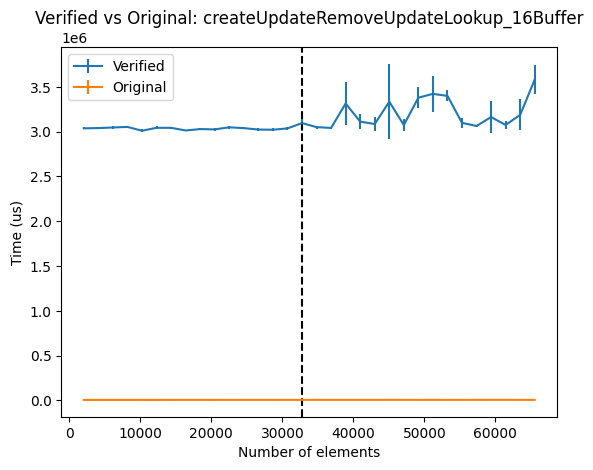

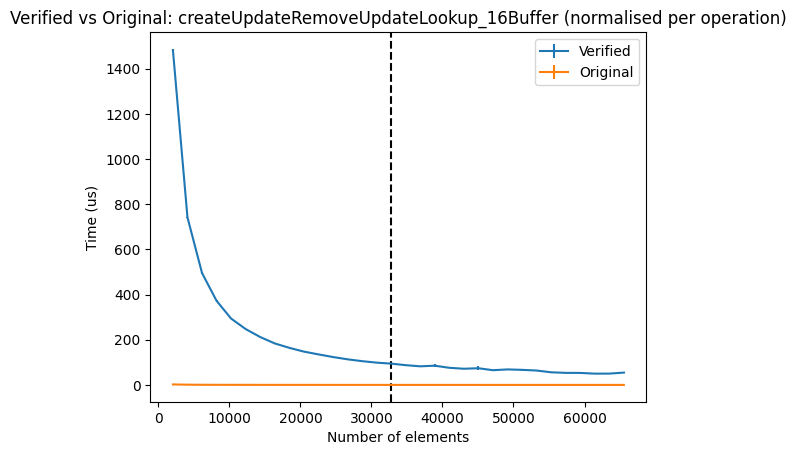

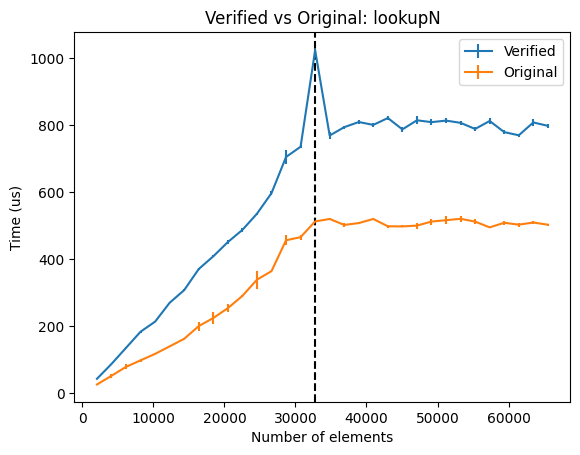

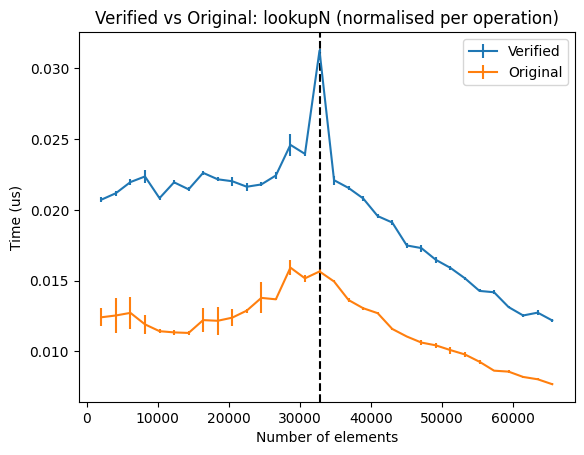

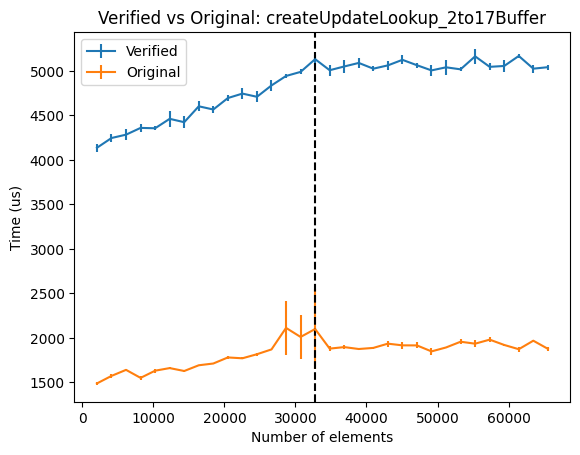

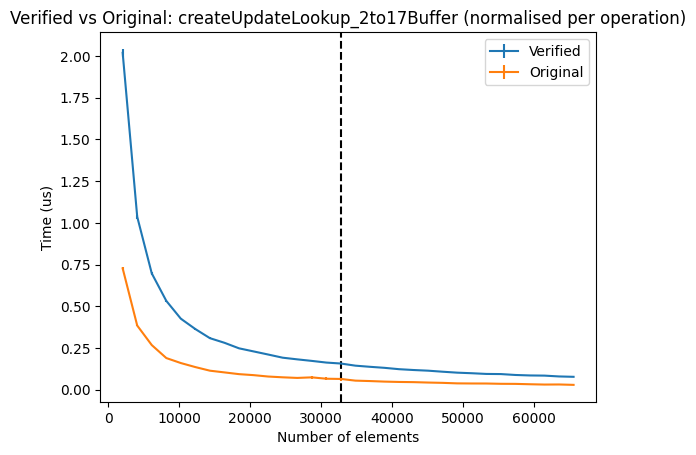

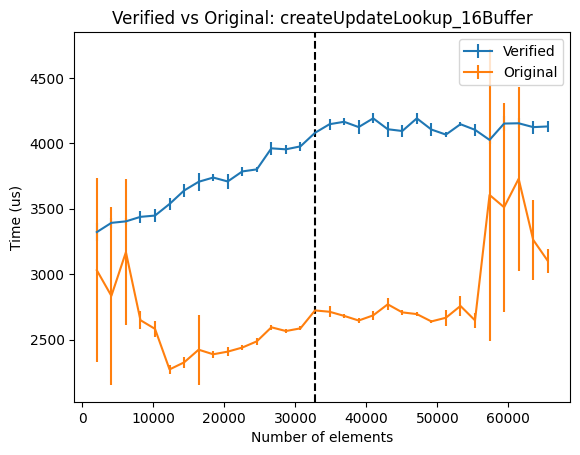

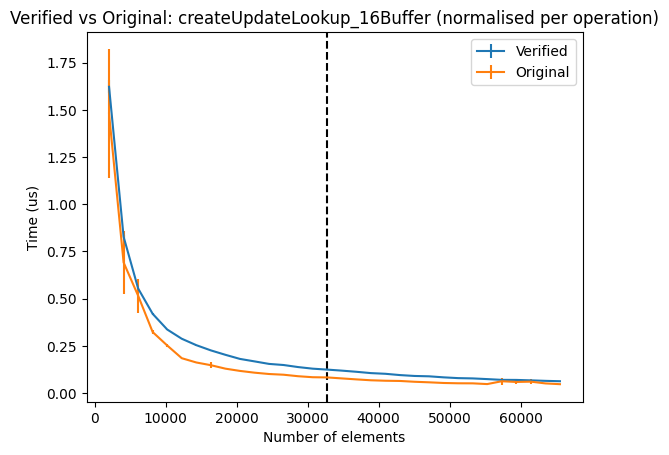

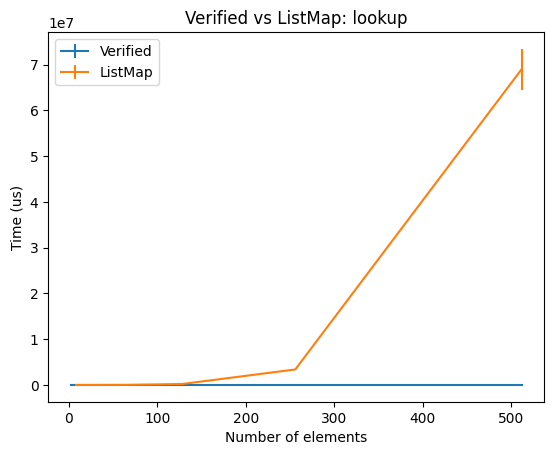

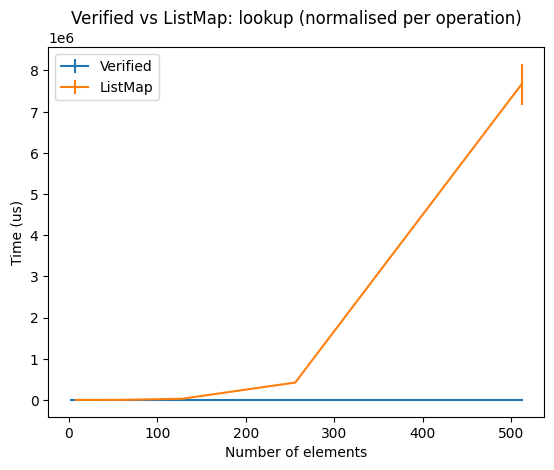

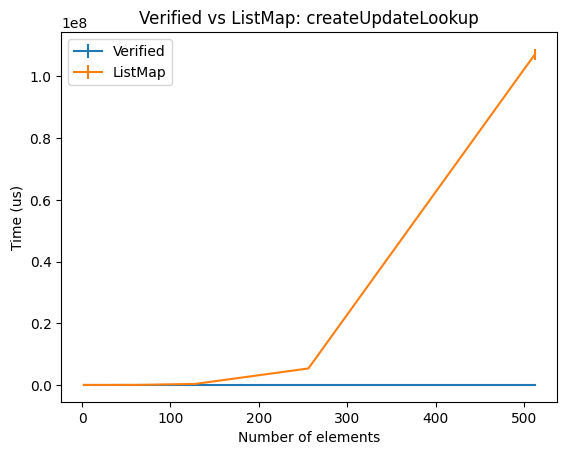

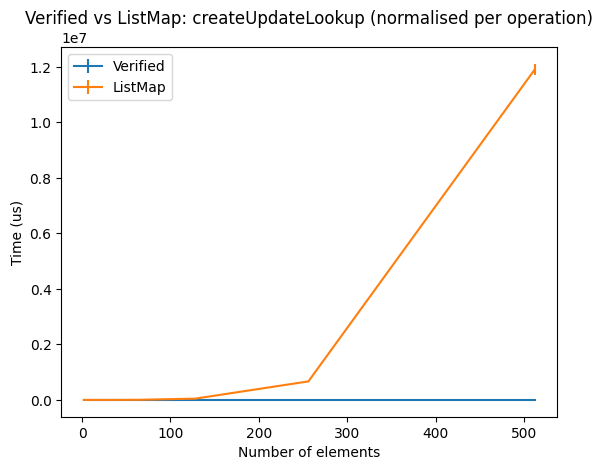

In [44]:
create_plots(benchmark_classes, benchmark_names, df)

In [45]:
data = """[info] Benchmark                                                                 (keysListName)  (n)  Mode  Cnt     Score     Error  Units
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    1  avgt   10     0.115 ±   0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    2  avgt   10     0.237 ±   0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    3  avgt   10     0.588 ±   0.007  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    4  avgt   10     1.655 ±   0.016  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    5  avgt   10     5.118 ±   0.050  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    6  avgt   10    20.158 ±   0.106  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    7  avgt   10    76.503 ±   0.669  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    8  avgt   10   304.751 ±   2.763  us/op
[info] LongListMapBenchmark.createUpdateLookup_ListMap                                      N/A    9  avgt   10  1385.114 ±  10.554  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    1  avgt   10     0.090 ±   0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    2  avgt   10     0.124 ±   0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    3  avgt   10     0.292 ±   0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    4  avgt   10     0.646 ±   0.005  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    5  avgt   10     1.278 ±   0.016  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    6  avgt   10     2.777 ±   0.015  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    7  avgt   10     5.723 ±   0.037  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    8  avgt   10    12.019 ±   0.134  us/op
[info] LongListMapBenchmark.createUpdateLookup_Original                                     N/A    9  avgt   10    28.450 ±   0.188  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    1  avgt   10     0.184 ±   0.001  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    2  avgt   10     0.236 ±   0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    3  avgt   10     0.333 ±   0.002  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    4  avgt   10     0.848 ±   0.011  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    5  avgt   10     1.816 ±   0.013  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    6  avgt   10     3.789 ±   0.029  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    7  avgt   10     7.723 ±   0.045  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    8  avgt   10    16.037 ±   0.159  us/op
[info] LongListMapBenchmark.createUpdateLookup_Verified                                     N/A    9  avgt   10    32.881 ±   0.223  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    3  avgt   10     0.094 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    4  avgt   10     0.308 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    5  avgt   10     1.151 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    6  avgt   10     4.940 ±   0.007  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    7  avgt   10    19.225 ±   0.083  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    8  avgt   10    83.202 ±   0.032  us/op
[info] LongListMapBenchmark.lookup_ListMap                                                  N/A    9  avgt   10   418.341 ±   0.239  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    1  avgt   10     0.036 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    2  avgt   10     0.047 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    3  avgt   10     0.051 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    4  avgt   10     0.088 ±   0.002  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    5  avgt   10     0.154 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    6  avgt   10     0.295 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    7  avgt   10     0.580 ±   0.009  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    8  avgt   10     1.423 ±   0.005  us/op
[info] LongListMapBenchmark.lookup_Original                                                 N/A    9  avgt   10     3.362 ±   0.022  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    1  avgt   10     0.036 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    2  avgt   10     0.050 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    3  avgt   10     0.062 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    4  avgt   10     0.120 ±   0.002  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    5  avgt   10     0.234 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    6  avgt   10     0.458 ±   0.001  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    7  avgt   10     0.878 ±   0.011  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    8  avgt   10     2.129 ±   0.015  us/op
[info] LongListMapBenchmark.lookup_Verified                                                 N/A    9  avgt   10     4.648 ±   0.019  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        2048  N/A  avgt   10  2187.650 ±  50.961  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        4096  N/A  avgt   10  2202.499 ±  11.125  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        6144  N/A  avgt   10  2227.342 ±  26.762  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                        8192  N/A  avgt   10  2266.720 ±  57.035  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       10240  N/A  avgt   10  2221.805 ±  20.011  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       12288  N/A  avgt   10  2278.365 ±  10.919  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       14336  N/A  avgt   10  2321.459 ±  52.886  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       16384  N/A  avgt   10  2361.788 ±  17.685  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       18432  N/A  avgt   10  2353.412 ±   9.914  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       20480  N/A  avgt   10  2408.610 ±  32.196  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       22528  N/A  avgt   10  2436.588 ±  14.310  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       24576  N/A  avgt   10  2522.113 ±  14.485  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       26624  N/A  avgt   10  2529.343 ±  57.550  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       28672  N/A  avgt   10  2544.208 ±  22.547  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       30720  N/A  avgt   10  2571.295 ±  13.375  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       32768  N/A  avgt   10  2653.015 ±  73.546  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       34816  N/A  avgt   10  2627.542 ±  18.041  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       36864  N/A  avgt   10  2708.427 ±  15.036  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       38912  N/A  avgt   10  2662.364 ±  52.020  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       40960  N/A  avgt   10  2668.776 ±  30.494  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       43008  N/A  avgt   10  2705.043 ±  17.212  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       45056  N/A  avgt   10  2731.419 ±  48.736  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       47104  N/A  avgt   10  2705.249 ±  16.520  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       49152  N/A  avgt   10  2674.882 ±  49.739  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       51200  N/A  avgt   10  2658.975 ±  65.198  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       53248  N/A  avgt   10  2636.538 ±  18.323  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       55296  N/A  avgt   10  2682.003 ±  26.154  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       57344  N/A  avgt   10  2721.203 ±  41.620  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       59392  N/A  avgt   10  2660.279 ±  33.864  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       61440  N/A  avgt   10  2690.948 ±  21.849  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       63488  N/A  avgt   10  2653.237 ±  27.995  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       65536  N/A  avgt   10  2710.423 ±  12.752  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        2048  N/A  avgt   10  3250.668 ±  27.028  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        4096  N/A  avgt   10  3330.675 ±  48.990  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        6144  N/A  avgt   10  3375.708 ±  40.515  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                        8192  N/A  avgt   10  3423.369 ±  44.415  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       10240  N/A  avgt   10  3476.466 ±  27.501  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       12288  N/A  avgt   10  3498.156 ±  51.071  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       14336  N/A  avgt   10  3544.034 ±  53.371  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       16384  N/A  avgt   10  3621.155 ±  23.501  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       18432  N/A  avgt   10  3642.732 ±  23.651  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       20480  N/A  avgt   10  3704.422 ±  25.605  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       22528  N/A  avgt   10  3762.221 ±  37.377  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       24576  N/A  avgt   10  3804.814 ±  49.366  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       26624  N/A  avgt   10  3792.507 ±  24.485  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       28672  N/A  avgt   10  3966.547 ±  39.937  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       30720  N/A  avgt   10  3948.180 ±  48.978  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       32768  N/A  avgt   10  4062.683 ±  23.321  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       34816  N/A  avgt   10  4067.776 ±  28.463  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       36864  N/A  avgt   10  4043.244 ±  45.643  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       38912  N/A  avgt   10  4010.519 ±  33.236  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       40960  N/A  avgt   10  3998.972 ±  38.073  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       43008  N/A  avgt   10  4023.377 ±  52.257  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       45056  N/A  avgt   10  4045.731 ±  60.896  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       47104  N/A  avgt   10  4108.775 ±  66.648  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       49152  N/A  avgt   10  4085.733 ±  42.190  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       51200  N/A  avgt   10  4104.523 ±  21.007  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       53248  N/A  avgt   10  4012.906 ±  33.780  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       55296  N/A  avgt   10  4007.256 ±  36.128  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       57344  N/A  avgt   10  4016.081 ±  21.200  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       59392  N/A  avgt   10  4074.817 ±  90.763  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       61440  N/A  avgt   10  3971.166 ±  51.427  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       63488  N/A  avgt   10  4045.289 ±  48.655  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       65536  N/A  avgt   10  4042.604 ±  29.123  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     2048  N/A  avgt   10  1501.094 ±  18.494  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     4096  N/A  avgt   10  1533.200 ±  33.818  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     6144  N/A  avgt   10  1608.941 ±  30.409  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                     8192  N/A  avgt   10  1606.618 ±   7.683  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    10240  N/A  avgt   10  1590.798 ±   7.624  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    12288  N/A  avgt   10  1623.794 ±  20.359  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    14336  N/A  avgt   10  1652.405 ±  11.197  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    16384  N/A  avgt   10  1694.000 ±  28.131  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    18432  N/A  avgt   10  1731.186 ±  11.876  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    20480  N/A  avgt   10  1799.258 ±  15.549  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    22528  N/A  avgt   10  1779.078 ±  14.729  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    24576  N/A  avgt   10  2287.277 ± 895.419  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    26624  N/A  avgt   10  2451.172 ± 794.477  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    28672  N/A  avgt   10  3343.483 ± 892.772  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    30720  N/A  avgt   10  2610.290 ± 311.095  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    32768  N/A  avgt   10  2847.515 ± 201.734  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    34816  N/A  avgt   10  2230.682 ± 391.022  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    36864  N/A  avgt   10  2079.579 ±  53.798  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    38912  N/A  avgt   10  3375.307 ± 499.232  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    40960  N/A  avgt   10  3104.652 ± 526.497  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    43008  N/A  avgt   10  2367.708 ± 522.760  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    45056  N/A  avgt   10  1927.038 ±  23.477  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    47104  N/A  avgt   10  2281.786 ± 268.255  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    49152  N/A  avgt   10  1917.997 ±   8.797  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    51200  N/A  avgt   10  2468.230 ± 411.001  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    53248  N/A  avgt   10  1968.970 ±  48.020  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    55296  N/A  avgt   10  2062.849 ± 204.336  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    57344  N/A  avgt   10  2234.650 ± 193.161  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    59392  N/A  avgt   10  1878.079 ±  16.579  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    61440  N/A  avgt   10  1893.204 ±  16.386  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    63488  N/A  avgt   10  1912.473 ±  22.127  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    65536  N/A  avgt   10  1967.785 ±  22.624  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     2048  N/A  avgt   10  2000.803 ±  11.399  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     4096  N/A  avgt   10  2042.041 ±  41.877  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     6144  N/A  avgt   10  2101.616 ±  17.327  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                     8192  N/A  avgt   10  2110.882 ±  17.003  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    10240  N/A  avgt   10  2218.447 ±  35.251  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    12288  N/A  avgt   10  2211.536 ±  38.309  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    14336  N/A  avgt   10  2285.196 ±  18.984  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    16384  N/A  avgt   10  2311.855 ±  48.411  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    18432  N/A  avgt   10  2350.854 ±  26.125  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    20480  N/A  avgt   10  2416.731 ±  12.462  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    22528  N/A  avgt   10  2433.255 ±  26.059  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    24576  N/A  avgt   10  2537.658 ±  34.073  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    26624  N/A  avgt   10  2588.508 ±  18.037  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    28672  N/A  avgt   10  2658.136 ±  48.924  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    30720  N/A  avgt   10  2678.702 ±  34.131  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    32768  N/A  avgt   10  2747.263 ±  35.718  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    34816  N/A  avgt   10  2741.936 ±  26.261  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    36864  N/A  avgt   10  2706.337 ±  16.172  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    38912  N/A  avgt   10  2714.965 ±  20.902  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    40960  N/A  avgt   10  2712.941 ±  41.391  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    43008  N/A  avgt   10  2712.597 ±  37.134  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    45056  N/A  avgt   10  2714.636 ±  28.373  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    47104  N/A  avgt   10  2755.320 ±  45.058  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    49152  N/A  avgt   10  2699.964 ±  31.386  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    51200  N/A  avgt   10  2741.093 ±  19.835  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    53248  N/A  avgt   10  2710.041 ±  23.859  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    55296  N/A  avgt   10  2707.903 ±  35.877  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    57344  N/A  avgt   10  2746.064 ±  29.444  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    59392  N/A  avgt   10  2744.795 ±  27.671  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    61440  N/A  avgt   10  2701.461 ±  17.858  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    63488  N/A  avgt   10  2755.948 ±  53.327  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    65536  N/A  avgt   10  2703.847 ±  59.372  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            2048  N/A  avgt   10  4649.186 ±  37.089  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            4096  N/A  avgt   10  4707.537 ±  27.241  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            6144  N/A  avgt   10  4755.847 ±  63.848  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original            8192  N/A  avgt   10  4761.286 ±  23.854  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           10240  N/A  avgt   10  4883.495 ±  43.817  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           12288  N/A  avgt   10  4874.568 ±  93.530  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           14336  N/A  avgt   10  4868.028 ±  53.792  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           16384  N/A  avgt   10  4968.983 ±  65.027  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           18432  N/A  avgt   10  4885.579 ±  83.392  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           20480  N/A  avgt   10  4917.991 ±  25.967  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           22528  N/A  avgt   10  5003.039 ±  30.618  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           24576  N/A  avgt   10  5033.583 ±  41.308  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           26624  N/A  avgt   10  5123.543 ±  36.744  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           28672  N/A  avgt   10  5086.828 ± 119.886  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           30720  N/A  avgt   10  5187.900 ±  35.054  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           32768  N/A  avgt   10  5233.783 ± 104.868  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           34816  N/A  avgt   10  5231.128 ± 202.591  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           36864  N/A  avgt   10  5138.395 ±  43.795  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           38912  N/A  avgt   10  5616.021 ±  36.742  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           40960  N/A  avgt   10  5144.281 ±  33.734  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           43008  N/A  avgt   10  5135.435 ±  19.390  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           45056  N/A  avgt   10  5125.161 ±  54.310  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           47104  N/A  avgt   10  5149.763 ±  37.123  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           49152  N/A  avgt   10  5239.285 ±  67.855  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           51200  N/A  avgt   10  5223.983 ±  43.748  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           53248  N/A  avgt   10  5139.727 ±  28.293  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           55296  N/A  avgt   10  5340.468 ±  58.825  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           57344  N/A  avgt   10  5226.320 ±  27.760  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           59392  N/A  avgt   10  5241.053 ±  86.475  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           61440  N/A  avgt   10  5199.472 ±  65.323  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           63488  N/A  avgt   10  5278.117 ±  24.175  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           65536  N/A  avgt   10  5179.800 ±  71.818  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            2048  N/A  avgt   10  5725.986 ±  66.077  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            4096  N/A  avgt   10  5736.851 ±  83.319  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            6144  N/A  avgt   10  5844.569 ±  75.874  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified            8192  N/A  avgt   10  5813.438 ±  49.306  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           10240  N/A  avgt   10  5998.963 ± 108.578  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           12288  N/A  avgt   10  6066.798 ±  99.161  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           14336  N/A  avgt   10  6184.481 ±  95.789  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           16384  N/A  avgt   10  6368.380 ±  82.197  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           18432  N/A  avgt   10  6233.460 ±  33.225  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           20480  N/A  avgt   10  6390.362 ±  81.857  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           22528  N/A  avgt   10  6529.438 ±  47.538  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           24576  N/A  avgt   10  6600.744 ±  37.299  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           26624  N/A  avgt   10  6635.387 ±  69.194  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           28672  N/A  avgt   10  6708.067 ±  39.999  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           30720  N/A  avgt   10  8168.239 ±  92.124  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           32768  N/A  avgt   10  6817.251 ±  55.377  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           34816  N/A  avgt   10  6831.992 ±  91.881  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           36864  N/A  avgt   10  6886.936 ±  35.278  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           38912  N/A  avgt   10  6870.885 ±  47.384  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           40960  N/A  avgt   10  6868.453 ±  39.540  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           43008  N/A  avgt   10  6791.316 ±  40.148  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           45056  N/A  avgt   10  6843.422 ±  75.657  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           47104  N/A  avgt   10  6807.955 ±  90.155  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           49152  N/A  avgt   10  6866.423 ±  38.055  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           51200  N/A  avgt   10  6927.436 ±  62.973  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           53248  N/A  avgt   10  6882.524 ±  42.096  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           55296  N/A  avgt   10  6888.785 ±  98.023  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           57344  N/A  avgt   10  6942.363 ± 156.795  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           59392  N/A  avgt   10  6808.143 ±  54.222  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           61440  N/A  avgt   10  6759.329 ±  33.689  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           63488  N/A  avgt   10  6863.639 ±  48.409  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           65536  N/A  avgt   10  6860.029 ±  44.052  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            2048  N/A  avgt   10    21.352 ±   0.108  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            4096  N/A  avgt   10    45.639 ±   0.903  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            6144  N/A  avgt   10    67.594 ±   0.364  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                            8192  N/A  avgt   10    88.308 ±   0.647  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           10240  N/A  avgt   10   111.415 ±   0.907  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           12288  N/A  avgt   10   138.226 ±   0.818  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           14336  N/A  avgt   10   164.822 ±   1.000  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           16384  N/A  avgt   10   191.925 ±   1.776  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           18432  N/A  avgt   10   218.539 ±   1.441  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           20480  N/A  avgt   10   244.779 ±   2.433  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           22528  N/A  avgt   10   288.818 ±   2.411  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           24576  N/A  avgt   10   330.781 ±   2.068  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           26624  N/A  avgt   10   367.324 ±   2.548  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           28672  N/A  avgt   10   411.955 ±   3.786  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           30720  N/A  avgt   10   458.663 ±   2.945  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           32768  N/A  avgt   10   503.482 ±   6.155  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           34816  N/A  avgt   10   507.660 ±   3.269  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           36864  N/A  avgt   10   504.268 ±   7.919  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           38912  N/A  avgt   10   508.096 ±   2.939  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           40960  N/A  avgt   10   700.181 ±   5.566  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           43008  N/A  avgt   10   509.064 ±   3.685  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           45056  N/A  avgt   10   501.864 ±   2.720  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           47104  N/A  avgt   10   499.338 ±   5.424  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           49152  N/A  avgt   10   511.777 ±   3.038  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           51200  N/A  avgt   10   500.470 ±   2.965  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           53248  N/A  avgt   10   507.609 ±   7.382  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           55296  N/A  avgt   10   499.647 ±   7.300  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           57344  N/A  avgt   10   514.749 ±   3.405  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           59392  N/A  avgt   10   509.426 ±   6.155  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           61440  N/A  avgt   10   516.185 ±   3.295  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           63488  N/A  avgt   10   506.313 ±   2.822  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           65536  N/A  avgt   10   494.647 ±   4.273  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            2048  N/A  avgt   10    44.765 ±   0.291  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            4096  N/A  avgt   10    90.803 ±   0.537  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            6144  N/A  avgt   10   123.486 ±   0.768  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                            8192  N/A  avgt   10   184.353 ±   1.151  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           10240  N/A  avgt   10   211.052 ±   3.167  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           12288  N/A  avgt   10   275.333 ±   2.424  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           14336  N/A  avgt   10   330.395 ±   2.509  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           16384  N/A  avgt   10   372.355 ±   3.003  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           18432  N/A  avgt   10   423.982 ±   2.396  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           20480  N/A  avgt   10   440.336 ±   3.396  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           22528  N/A  avgt   10   490.277 ±  13.121  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           24576  N/A  avgt   10   554.877 ±   7.673  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           26624  N/A  avgt   10   650.501 ±   3.915  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           28672  N/A  avgt   10   682.779 ±   4.202  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           30720  N/A  avgt   10   701.805 ±   6.179  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           32768  N/A  avgt   10   820.166 ±   4.342  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           34816  N/A  avgt   10   805.784 ±   4.634  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           36864  N/A  avgt   10   829.968 ±   6.867  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           38912  N/A  avgt   10   789.245 ±   5.021  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           40960  N/A  avgt   10   790.411 ±  14.535  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           43008  N/A  avgt   10   814.142 ±   5.133  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           45056  N/A  avgt   10   803.403 ±   4.609  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           47104  N/A  avgt   10   818.104 ±  10.316  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           49152  N/A  avgt   10   823.571 ±   4.798  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           51200  N/A  avgt   10   816.962 ±   5.012  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           53248  N/A  avgt   10   804.999 ±   4.437  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           55296  N/A  avgt   10   822.569 ±   4.568  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           57344  N/A  avgt   10   799.514 ±   4.384  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           59392  N/A  avgt   10   789.516 ±  10.551  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           61440  N/A  avgt   10   826.785 ±   7.387  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           63488  N/A  avgt   10   778.836 ±   4.362  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           65536  N/A  avgt   10   819.363 ±   5.763  us/op""".strip().split("\n")

data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["MutableLongMapBenchmark", "LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if n in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

{'MutableLongMapBenchmark': ['createUpdateRemoveUpdateLookup_16Buffer',
  'lookupN',
  'createUpdateLookup_2to17Buffer',
  'createUpdateLookup_16Buffer'],
 'LongListMapBenchmark': ['lookup', 'createUpdateLookup']}

In [46]:
2**15

32768

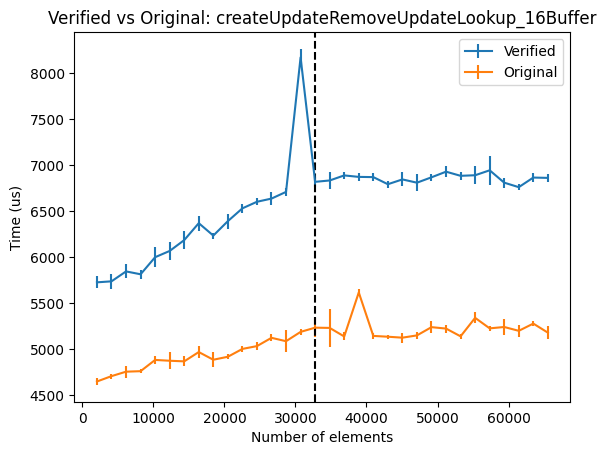

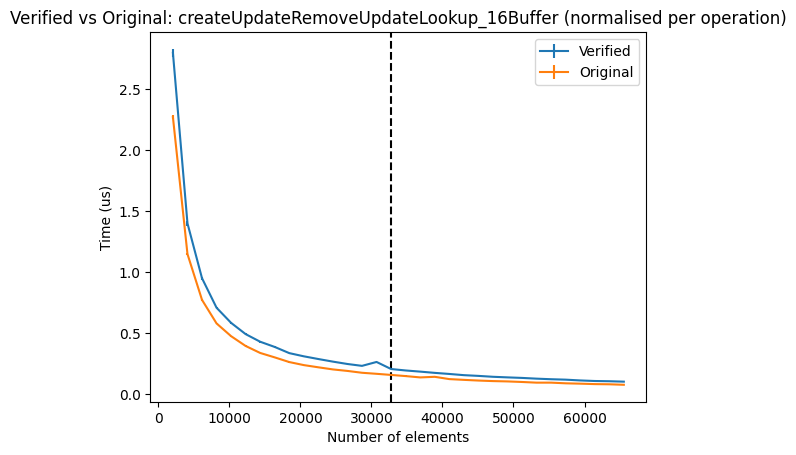

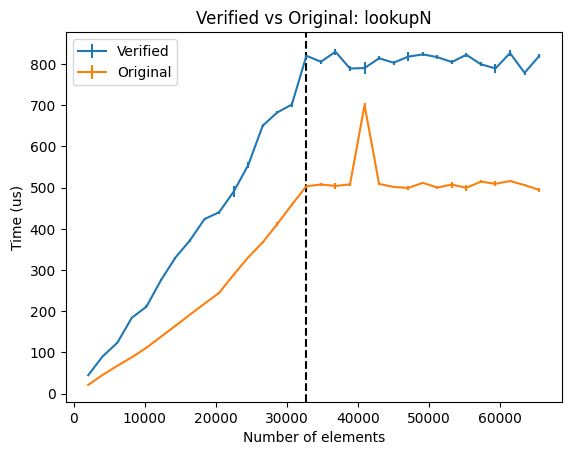

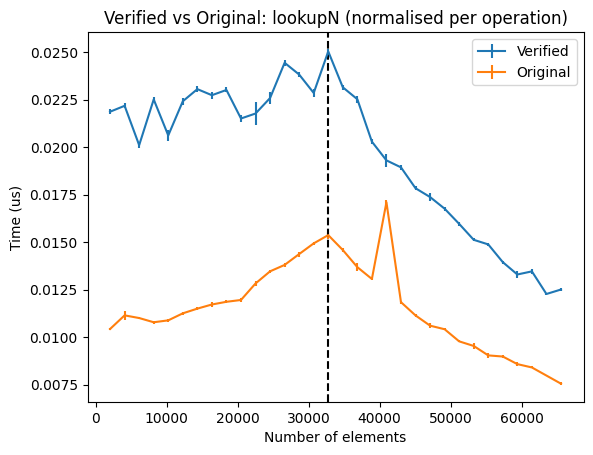

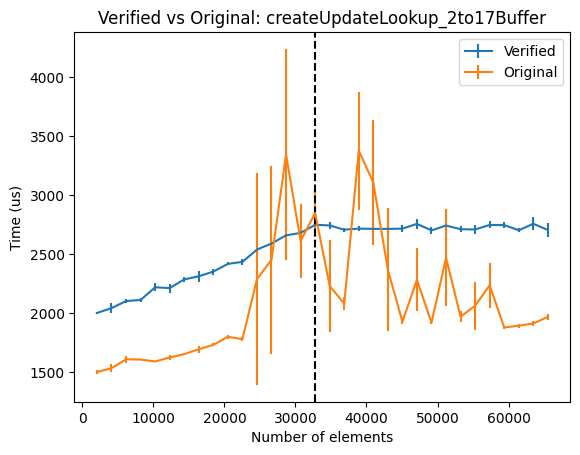

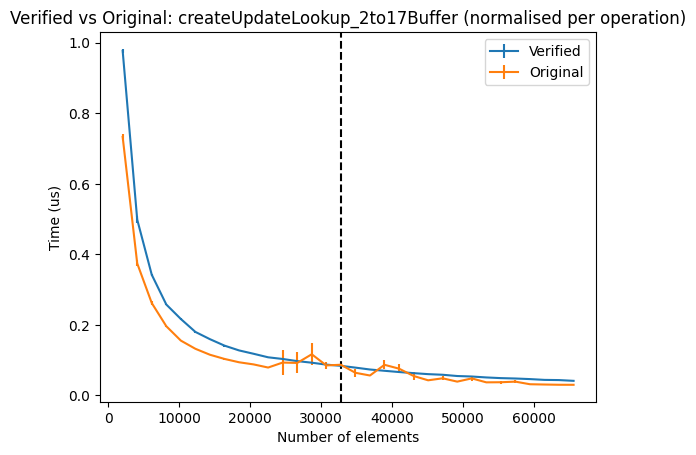

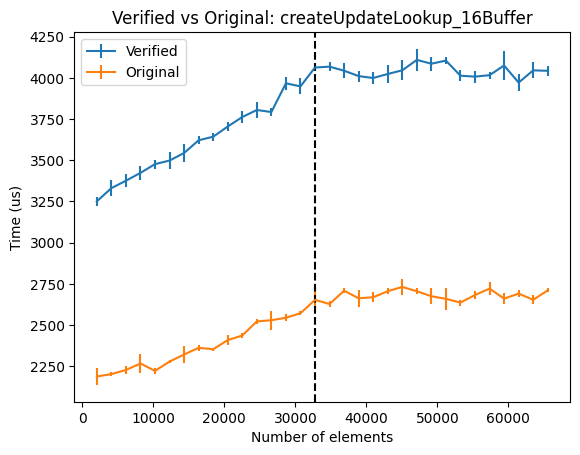

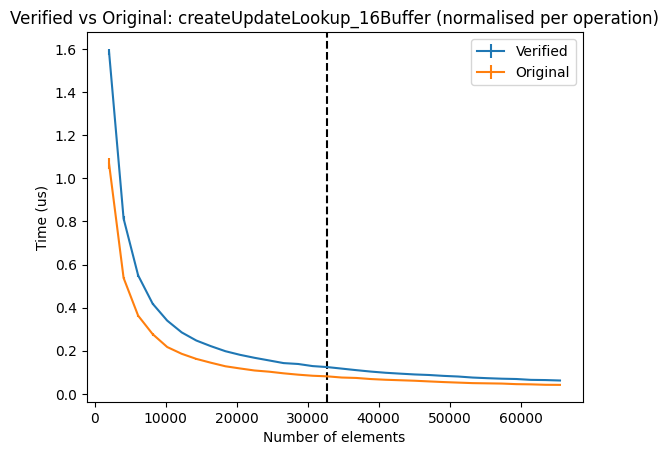

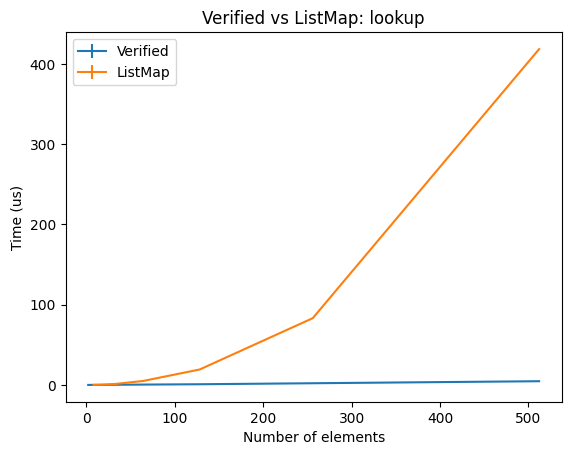

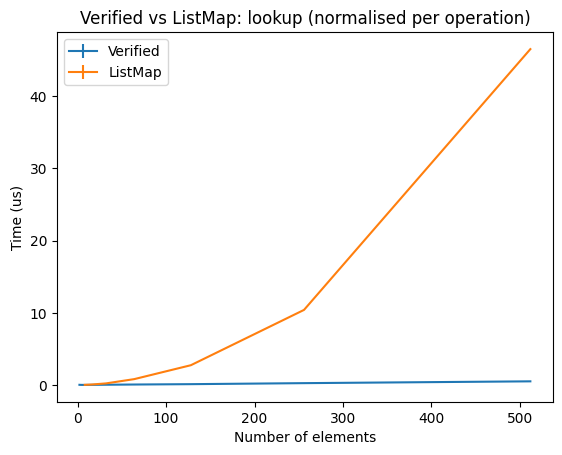

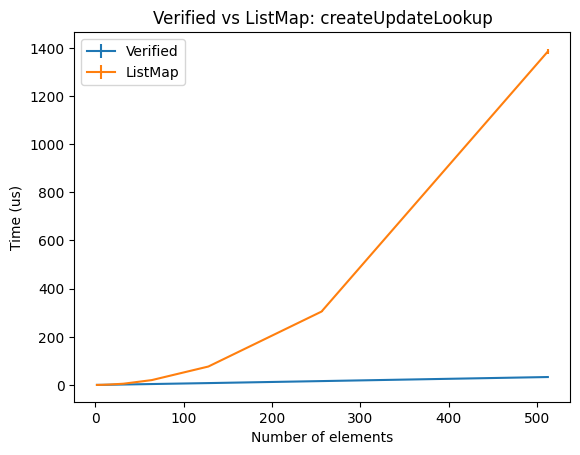

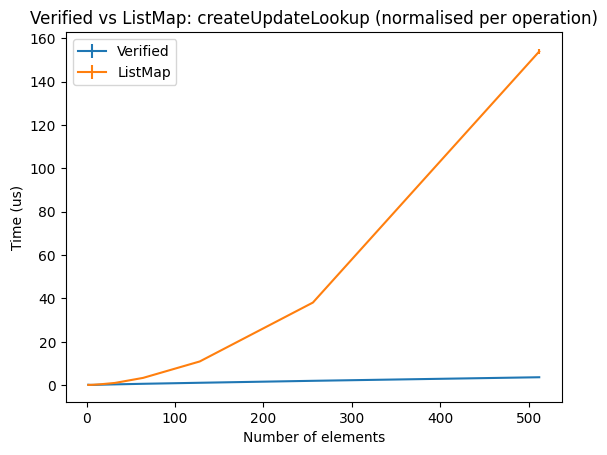

In [47]:
create_plots(benchmark_classes, benchmark_names, df)